## Финальный проект

- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from src.preprocessing import new_item_features, new_user_features, train_test_preprocessing, get_important_features, get_final_recomendation

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам / Загрузка данных

In [5]:
train_df = pd.read_csv('../data/retail_train.csv')
test_df = pd.read_csv('../data/retail_test1.csv')

item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

### Изучение датасета

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88734 entries, 0 to 88733
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            88734 non-null  int64  
 1   basket_id          88734 non-null  int64  
 2   day                88734 non-null  int64  
 3   item_id            88734 non-null  int64  
 4   quantity           88734 non-null  int64  
 5   sales_value        88734 non-null  float64
 6   store_id           88734 non-null  int64  
 7   retail_disc        88734 non-null  float64
 8   trans_time         88734 non-null  int64  
 9   week_no            88734 non-null  int64  
 10  coupon_disc        88734 non-null  float64
 11  coupon_match_disc  88734 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 8.1 MB


In [8]:
train_df.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39000,364,-0.60000,1631,1,0.00000,0.00000
1,2375,26984851472,1,1033142,1,0.82000,364,0.00000,1631,1,0.00000,0.00000
2,2375,26984851472,1,1036325,1,0.99000,364,-0.30000,1631,1,0.00000,0.00000
3,2375,26984851472,1,1082185,1,1.21000,364,0.00000,1631,1,0.00000,0.00000
4,2375,26984851472,1,8160430,1,1.50000,364,-0.39000,1631,1,0.00000,0.00000


In [9]:
train_df.tail(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2396799,1613,41655820646,663,16102849,1,2.00000,3262,-1.15000,1231,95,0.00000,0.00000
2396800,1001,41655829421,663,13217063,1,1.69000,3131,0.00000,2231,95,0.00000,0.00000
2396801,1001,41655829421,663,13217800,1,1.69000,3131,0.00000,2231,95,0.00000,0.00000
2396802,1167,41656790510,663,6410462,22451,43.98000,3385,-0.65000,1059,95,0.00000,0.00000
2396803,1167,41656790510,663,6430664,1,8.00000,3385,0.00000,1059,95,0.00000,0.00000


In [10]:
test_df.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49000,446,0.00000,52,96,0.00000,0.00000
1,588,41652838477,664,1024426,1,6.29000,388,0.00000,8,96,0.00000,0.00000
2,2070,41652857291,664,995242,5,9.10000,311,-0.60000,46,96,0.00000,0.00000
3,1602,41665647035,664,827939,1,7.99000,334,0.00000,1741,96,0.00000,0.00000
4,1602,41665647035,664,927712,1,0.59000,334,-0.40000,1741,96,0.00000,0.00000


In [11]:
test_df.tail(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
88729,98,41944918665,684,945779,2,2.00000,421,0.00000,1705,98,0.00000,0.00000
88730,98,41944918665,684,993617,2,2.00000,421,0.00000,1705,98,0.00000,0.00000
88731,98,41944918665,684,1128647,2,2.00000,421,0.00000,1705,98,0.00000,0.00000
88732,98,41944918665,684,9526886,2,0.60000,421,0.00000,1705,98,0.00000,0.00000
88733,98,41944918665,684,15972479,1,1.00000,421,0.00000,1705,98,0.00000,0.00000


In [12]:
print(train_df.shape)

(2396804, 12)


In [13]:
print(test_df.shape)

(88734, 12)


### Количественные переменные

In [14]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2396804.00000,1271.90389,726.56440,1.00000,655.00000,1271.00000,1914.00000,2500.00000
basket_id,2396804.00000,33366432676.47503,4284798175.92877,26984851472.00000,30087143433.00000,32419978306.00000,35145801967.00000,41656790510.00000
day,2396804.00000,363.97701,175.93855,1.00000,216.00000,366.00000,515.00000,663.00000
item_id,2396804.00000,2827247.09222,3732797.65928,25671.00000,916993.00000,1027569.00000,1132178.00000,18024556.00000
quantity,2396804.00000,100.37634,1152.37887,0.00000,1.00000,1.00000,1.00000,89638.00000
sales_value,2396804.00000,3.10082,4.21023,0.00000,1.29000,2.00000,3.49000,840.00000
store_id,2396804.00000,3048.22717,8785.54247,1.00000,330.00000,370.00000,422.00000,34280.00000
retail_disc,2396804.00000,-0.54007,1.24582,-130.02000,-0.69000,-0.02000,0.00000,3.99000
trans_time,2396804.00000,1561.71397,401.56911,0.00000,1307.00000,1614.00000,1844.00000,2359.00000
week_no,2396804.00000,52.68156,25.13310,1.00000,32.00000,53.00000,74.00000,95.00000


In [15]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,88734.00000,1266.43526,719.81460,1.00000,672.00000,1272.00000,1900.00000,2500.00000
basket_id,88734.00000,41804724692.35515,81260181.63756,41652823310.00000,41730780848.00000,41809521175.00000,41878556671.00000,41944918665.00000
day,88734.00000,674.54928,6.15381,664.00000,669.00000,675.00000,680.00000,684.00000
item_id,88734.00000,3579572.74764,4729673.95769,27658.00000,923746.00000,1037965.00000,5581910.00000,18184178.00000
quantity,88734.00000,105.26663,1195.97989,0.00000,1.00000,1.00000,1.00000,45475.00000
sales_value,88734.00000,3.09463,3.83189,0.00000,1.25000,2.12000,3.49000,230.00000
store_id,88734.00000,4287.67028,10537.75851,19.00000,333.00000,380.00000,427.00000,34280.00000
retail_disc,88734.00000,-0.56851,1.42921,-180.00000,-0.70000,-0.09000,0.00000,0.59000
trans_time,88734.00000,1566.64958,372.17229,0.00000,1322.00000,1606.00000,1831.00000,2359.00000
week_no,88734.00000,97.03133,0.81845,96.00000,96.00000,97.00000,98.00000,98.00000


### Обработка выбросов и пропусков

In [16]:
train_df.isnull().sum()

user_id              0
basket_id            0
day                  0
item_id              0
quantity             0
sales_value          0
store_id             0
retail_disc          0
trans_time           0
week_no              0
coupon_disc          0
coupon_match_disc    0
dtype: int64

In [17]:
test_df.isnull().sum()

user_id              0
basket_id            0
day                  0
item_id              0
quantity             0
sales_value          0
store_id             0
retail_disc          0
trans_time           0
week_no              0
coupon_disc          0
coupon_match_disc    0
dtype: int64

### Корреляция признаков

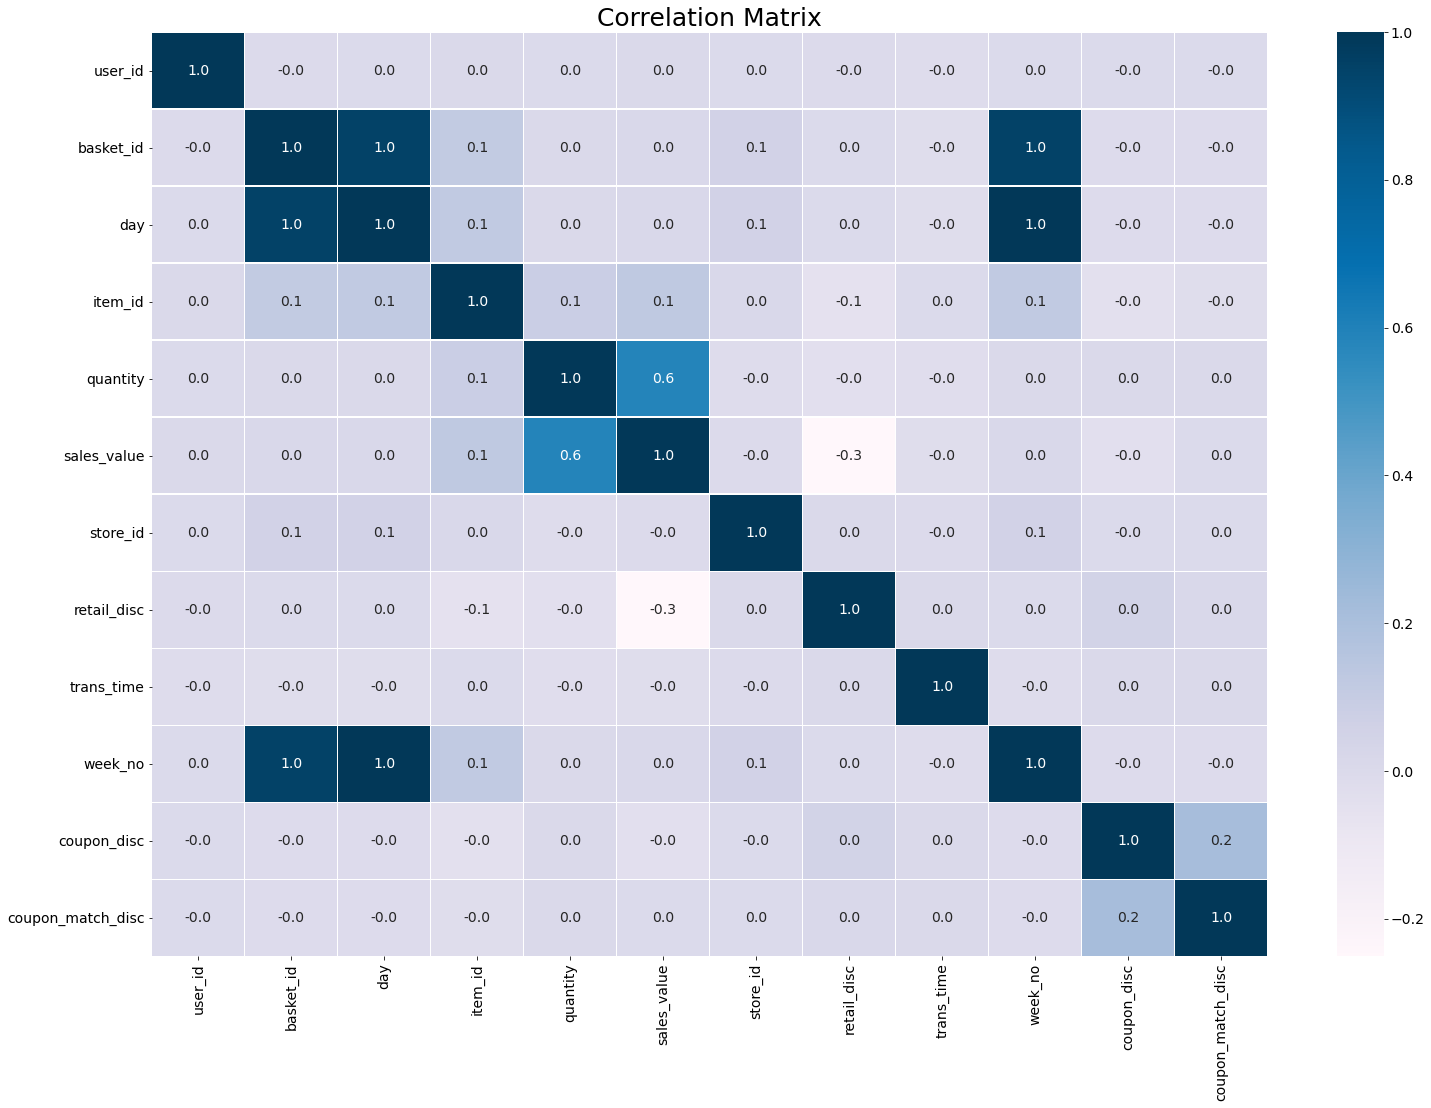

In [18]:
# Correlation Matrix
f, ax = plt.subplots(figsize = [25, 17])
sns.heatmap(train_df.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

### Column processing

In [19]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

### First level model

In [20]:
VAL_SIZE = 5

train_1 = train_df[train_df['week_no'] < train_df['week_no'].max() - (VAL_SIZE)]
val_1 = train_df[train_df['week_no'] >= train_df['week_no'].max() - (VAL_SIZE)]

train_2 = val_1.copy()

In [21]:
n_items_before = train_1['item_id'].nunique()
train_1 = prefilter_items(train_1, item_features=item_features, take_n_popular = 217)
n_items_after = train_1['item_id'].nunique()

print(f'Decreased # items from {n_items_before} to {n_items_after}')

Decreased # items from 85828 to 218


In [22]:
recommender = MainRecommender(train_1)

In [23]:
items_emb_df = recommender.items_emb_df
users_emb_df = recommender.users_emb_df

### Features engineering

![image](0_PSZK-yUYwQJsN5A8.png) 

In [24]:
item_features = new_item_features(train_2, item_features, items_emb_df)
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,coupon_disc,quantity_of_sales,quantity_of_sales_per_week,qnt_of_sales_per_dep,qnt_of_sales_per_item_per_dep_per_week,qnt_of_sales_per_sub_commodity_desc,qnt_of_sales_per_item_per_sub_commodity_desc_per_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.00000,112255,0.13731,101,0.13467
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.00000,226,0.05858,225,0.06443
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.00000,2436,0.10227,356,0.14027
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.00000,112255,0.13731,141,0.14157
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.00000,112255,0.13731,183,0.11868


In [25]:
user_features = new_user_features(train_2, user_features, users_emb_df)
user_features.head()

,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,mean_time,age,income,kids,average_basket,sum_per_week
0,A,Homeowner,2 Adults No Kids,2,1,15.82309,13.86764,1.88256,-9.32234,15.73276,14.08196,16.64553,-1.03460,21.04892,0.25061,13.80638,9.73348,1.83576,-0.43570,15.37441,1324.80371,70,45,0,2.48729,44.35667
1,A,Homeowner,2 Adults No Kids,2,7,2.20405,9.32236,11.21600,12.49866,10.21682,-1.40122,11.46530,14.42783,-3.42990,3.56456,26.32336,15.45744,1.07208,7.42036,4.81192,1622.86292,50,70,0,2.54726,74.29500
2,U,Unknown,2 Adults Kids,3,8,10.73171,8.68825,7.38002,4.64519,17.09263,6.46770,13.54320,18.54459,13.30731,17.03843,4.79543,13.44179,12.24558,5.30639,9.42011,1824.99011,30,30,1,2.41379,81.66667
3,U,Homeowner,2 Adults Kids,4,13,10.91672,9.01209,14.10982,22.42173,16.40961,13.50115,11.02057,8.42123,3.68782,-7.51301,12.06115,9.31111,13.94104,3.00398,9.16227,1608.36365,30,95,2,6.44618,177.27000
4,B,Homeowner,Single Female,1,16,2.12064,-0.45703,-3.58453,1.78883,5.31913,-2.35262,5.86892,-5.02497,-3.25148,2.19635,1.43573,2.01542,3.07874,7.47685,2.97038,1317.42859,50,70,0,2.26286,2.64000


In [26]:
X_train, y_train = train_test_preprocessing(train_2, train_1, recommender, item_features, user_features)

In [27]:
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
cat_features

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc']

In [28]:
X_train[cat_features + ['user_id', 'item_id']] = X_train[cat_features + ['user_id', 'item_id']].astype('category')

In [29]:
X_test_df, y_test_df = train_test_preprocessing(test_df, train_1, recommender, item_features, user_features)
X_test_df[cat_features + ['user_id', 'item_id']] = X_test_df[cat_features + ['user_id', 'item_id']].astype('category')

### Second level model

In [30]:
lgbc = LGBMClassifier(objective='binary', categorical_feature = cat_features)

### Отбор признаков

In [31]:
basic_features = get_important_features(lgbc, X_train, y_train)
basic_features

['user_id',
 'item_id',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 '0_x',
 '1_x',
 '2_x',
 '3_x',
 '4_x',
 '5_x',
 '6_x',
 '7_x',
 '8_x',
 '9_x',
 '10_x',
 '11_x',
 '12_x',
 '13_x',
 '14_x',
 'coupon_disc',
 'quantity_of_sales',
 'qnt_of_sales_per_dep',
 'qnt_of_sales_per_item_per_dep_per_week',
 'qnt_of_sales_per_sub_commodity_desc',
 'qnt_of_sales_per_item_per_sub_commodity_desc_per_week',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 '0_y',
 '1_y',
 '2_y',
 '3_y',
 '4_y',
 '5_y',
 '6_y',
 '7_y',
 '8_y',
 '9_y',
 '10_y',
 '11_y',
 '12_y',
 '13_y',
 '14_y',
 'mean_time',
 'age',
 'income',
 'kids',
 'average_basket',
 'sum_per_week']

### Прогнозирование / Алгоритм - LGBMClassifier

In [32]:
lgbc = LGBMClassifier(categorical_feature=cat_features, n_estimators=525)
lgbc.fit(X_train[basic_features], y_train)

LGBMClassifier(categorical_feature=['manufacturer', 'department', 'brand',
                                    'commodity_desc', 'sub_commodity_desc',
                                    'curr_size_of_product',
                                    'marital_status_code', 'homeowner_desc',
                                    'hh_comp_desc', 'household_size_desc'],
               n_estimators=525)

### Целевая метрика - precision@5 > 0.27%

In [33]:
test_preds_proba = lgbc.predict_proba(X_test_df[basic_features])[:, 1]

result = get_final_recomendation(X_test_df, test_preds_proba, test_df, train_1)

In [34]:
result.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.33782493368700267

In [35]:
X_test_2, y_test_2 = train_test_preprocessing(train_df, train_1, recommender, item_features, user_features)
X_test_2[cat_features + ['user_id', 'item_id']] = X_test_2[cat_features + ['user_id', 'item_id']].astype('category')

In [36]:
test_preds_proba = lgbc.predict_proba(X_test_2[basic_features])[:, 1]

result = get_final_recomendation(X_test_2, test_preds_proba, train_df, train_1)

In [37]:
result.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.9517406962785118

### Сохранение результатов

In [38]:
result.drop('actual', axis=1, inplace=True)

In [39]:
result.to_csv('recommendations.csv', index=False)